<a href="https://colab.research.google.com/github/tristantoupin/ECSE415-FinalProject/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

#Data Preparation for CNN

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
global_path = 'gdrive/My Drive/Mcgill/U4/Fall 2018/ECSE 415/assignment/final_project/'
data_folder = 'MIO-TCD-Classification.tar'
path_to_train = None
path_to_test = None  
  
# import tarfile
# print(global_path + data_folder)
# tar_f = tarfile.open(global_path + data_folder)
# tar_f.extractall(global_path + data_folder)
path_to_train = 'train/'
path_to_test = 'test/'
 
class_ids = [x for x in os.listdir(path_to_train)]

In [18]:
print(class_ids)

['bicycle', 'work_van', 'background', 'bus', 'motorcycle', 'single_unit_truck', 'articulated_truck', 'pickup_truck', 'car', 'non-motorized_vehicle', 'pedestrian']


In [0]:
def plot_images(list_of_images, max_col = 4):
    n = len(list_of_images)
    if n == 1:
        plt.imshow(list_of_images[0], cmap="gray"); plt.axis('off'); plt.show()
    else:
        # get number of columns and rows required
        r, c = 1, n
        if n > max_col:
            c = max_col
            r = int(math.ceil(n/max_col))
    
        fig = plt.figure(figsize=(20, max_col * r))
        for i, (img) in enumerate(list_of_images):
            ax = fig.add_subplot(r, c, (i+1))
            ax.set_title("Image " + str(i))
            ax.axis('off')
            ax.imshow(img, cmap="gray")

In [0]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]
  
def get_train_data(path_x, path_y, num_ = 0):
    X, y = [], []
    for c, id_ in enumerate(class_ids):
      print("Class ID: %s is changed to ID: %s." % (id_, c))
      class_imgs = os.listdir(path_to_train + id_)
      for img in class_imgs[:num_]:
        img = path_to_train + id_ + '/' + img
        y.append(c)
        X.append(cv2.imread(img, 0))
    xs, ys = unison_shuffled_copies(np.array(X), np.array(y))
    return xs, ys

In [21]:
X, y = get_train_data(path_to_train, path_to_train, 100)

Class ID: bicycle is changed to ID: 0.
Class ID: work_van is changed to ID: 1.
Class ID: background is changed to ID: 2.
Class ID: bus is changed to ID: 3.
Class ID: motorcycle is changed to ID: 4.
Class ID: single_unit_truck is changed to ID: 5.
Class ID: articulated_truck is changed to ID: 6.
Class ID: pickup_truck is changed to ID: 7.
Class ID: car is changed to ID: 8.
Class ID: non-motorized_vehicle is changed to ID: 9.
Class ID: pedestrian is changed to ID: 10.


In [0]:
def pad_images(img_list, result_shape):
    BLACK = [0,0,0]
    result = []

    for i, img in enumerate(img_list):
        height_adjust = result_shape[0] - img.shape[0]
        width_adjust = result_shape[1] - img.shape[1]
        
        top = math.ceil(height_adjust / 2)
        bot = height_adjust - top
        left = math.ceil(width_adjust / 2)
        right = width_adjust - left
            
        new_img = cv2.copyMakeBorder(img, top, bot, left, right, cv2.BORDER_CONSTANT, value=BLACK)
        
        result.append(cv2.resize(new_img, (64, 64)))
    return np.array(result)
  
largest_width = np.max([x.shape[0] for x in X])
largest_height = np.max([x.shape[1] for x in X])

X = pad_images(X, (largest_width, largest_height))

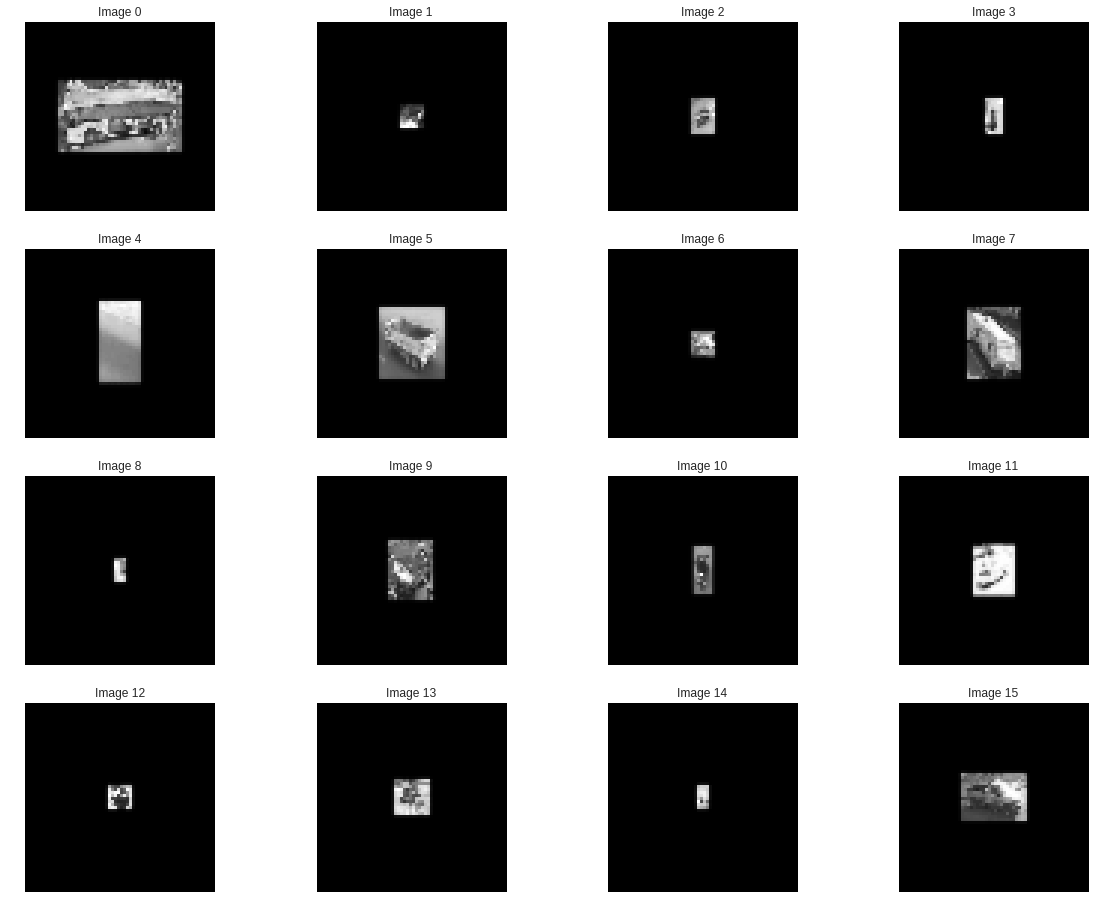

In [40]:
plot_images(X[:16])

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

In [46]:
batch_size = 1024
num_classes = 11
epochs = 40

# test and training dataset sizes
train_test_split = 0.7
split_val = int(len(X) * 0.7)

# input image dimensions
img_rows, img_cols = X[0].shape

770


In [43]:
# the data, split between train and val sets
(x_train, y_train), (x_val, y_val) = (X[:split_val],y[:split_val]), (X[split_val:],y[split_val:]) 
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'val samples')

x_train shape: (800, 64, 64, 1)
800 train samples
300 val samples


In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode='nearest')

datagen.fit(x_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(x_val)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)

In [45]:
model_cnn_2 = Sequential()
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu',input_shape=input_shape))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_2.add(BatchNormalization())
model_cnn_2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn_2.add(Dropout(0.1))

model_cnn_2.add(Flatten())
model_cnn_2.add(Dense(512, activation='relu'))
model_cnn_2.add(Dropout(0.3))
model_cnn_2.add(Dense(num_classes, activation='softmax'))

optimizer = keras.optimizers.Nadam(lr=0.002,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

# Set our optimizer and loss function (similar settings to our CAE approach)
model_cnn_2.compile(loss = keras.losses.categorical_crossentropy,
            optimizer = optimizer,
            metrics = ['categorical_accuracy'])

# model_cnn_2.summary()

# callbacks = [
#     ReduceLROnPlateau(monitor='val_categorical_accuracy', 
#                       factor=0.1, patience=5,
#                       min_delta=0.0001, mode='auto',
#                       cooldown=0, verbose=1, 
#                       min_lr=0),
# ]
hist = model_cnn_2.fit_generator(train_generator,
          steps_per_epoch= 14000 // batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(x_val, y_val),
#           callbacks = callbacks,
          )


score = model_cnn_2.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/40
218/218 [==============================] - 21s 94ms/step - loss: 3.1768 - categorical_accuracy: 0.2012 - val_loss: 2.2504 - val_categorical_accuracy: 0.1667
Epoch 2/40
218/218 [==============================] - 17s 80ms/step - loss: 1.9015 - categorical_accuracy: 0.3031 - val_loss: 2.2958 - val_categorical_accuracy: 0.2433
Epoch 3/40
218/218 [==============================] - 17s 80ms/step - loss: 1.7298 - categorical_accuracy: 0.3602 - val_loss: 7.1396 - val_categorical_accuracy: 0.1000
Epoch 4/40
218/218 [==============================] - 17s 80ms/step - loss: 1.5801 - categorical_accuracy: 0.4031 - val_loss: 6.7460 - val_categorical_accuracy: 0.1667
Epoch 5/40
 46/218 [=====>........................] - ETA: 13s - loss: 1.5260 - categorical_accuracy: 0.4256

KeyboardInterrupt: ignored